In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from recognizer.raw_samples import load_raw_suite
from sklearn.model_selection import train_test_split
import models.LSTM as lstm
import models.utils as models_utils

import warnings
warnings.filterwarnings('ignore')

path = "data/unpacked"
path_train = "data/train"
path_test = "data/test"

features = 17
window = 128
resample_f = 100

# train and test 
# --------------------------------------------------

train_suite = load_raw_suite(path_train)
test_suite = load_raw_suite(path_test)
train_suite.resample(resample_f)
test_suite.resample(resample_f)
print(train_suite)
print(test_suite)


X_train, y_train = lstm.load_data(train_suite, window_size=window)
X_test, y_test = lstm.load_data(test_suite, window_size=window)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)



data/train: length 95, resample to 100Hz
data/test: length 29, resample to 100Hz
Loading data...
Done

Loading data...
Done



------------------------------
| Train and test data shapes |
------------------------------
X_train shape:  (2690, 128, 17)
y_train shape:  (2690, 6)
X_test shape:  (895, 128, 17)
y_test shape:  (895, 6)


----------------------------
| Train / test split [%] |
----------------------------


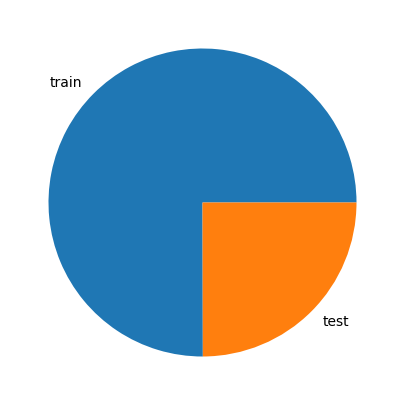



----------------------------
| Class distribution train |
----------------------------
chodz         962
chodz_reka    714
schod         496
wchod         392
upade          64
siada          62
Name: count, dtype: int64


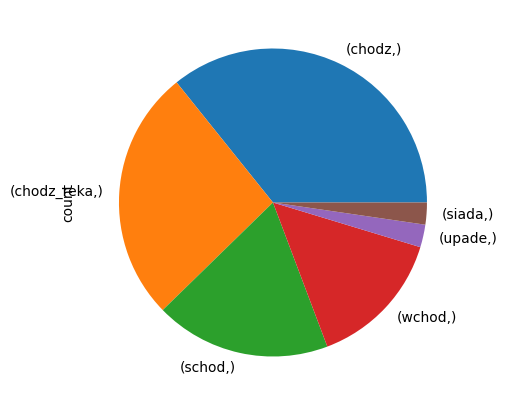



---------------------------
| Class distribution test |
---------------------------
chodz_reka    338
chodz         182
wchod         151
schod         145
upade          43
siada          36
Name: count, dtype: int64


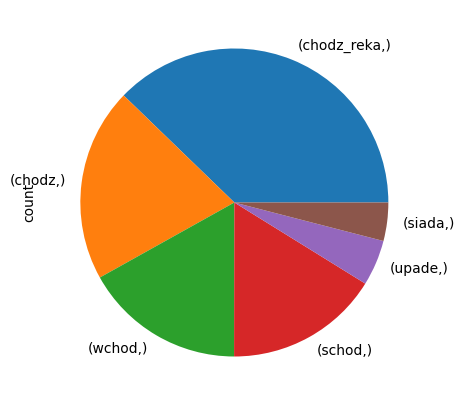

In [6]:
lstm.train_test_info(X_train, y_train, X_test, y_test)

In [7]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
print(timesteps)
print(input_dim)

128
17


In [8]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

epochs = 15
batch_size = 32
n_hidden = 32


In [9]:
model = Sequential()
model.add(BatchNormalization(input_shape=(timesteps, input_dim)))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim), recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(len(models_utils.labels), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 128, 17)           68        
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 32)                6400      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 6666 (26.04 KB)
Trainable params: 6632 (25.91 KB)
Non-trainable params: 34 (136.00 Byte)
_________________________________________________________________


In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
from keras.callbacks import EarlyStopping

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test))

Epoch 1/15


85/85 [==============================] - 9s 51ms/step - loss: 1.0156 - accuracy: 0.6829 - val_loss: 0.9106 - val_accuracy: 0.6592
Epoch 2/15
85/85 [==============================] - 4s 47ms/step - loss: 0.5729 - accuracy: 0.8108 - val_loss: 0.8290 - val_accuracy: 0.6715
Epoch 3/15
85/85 [==============================] - 4s 46ms/step - loss: 0.4611 - accuracy: 0.8357 - val_loss: 1.0703 - val_accuracy: 0.6179
Epoch 4/15
85/85 [==============================] - 4s 48ms/step - loss: 0.4139 - accuracy: 0.8610 - val_loss: 1.0333 - val_accuracy: 0.6235
Epoch 5/15
85/85 [==============================] - 4s 47ms/step - loss: 0.3572 - accuracy: 0.8818 - val_loss: 1.0435 - val_accuracy: 0.6402
Epoch 6/15
85/85 [==============================] - 4s 46ms/step - loss: 0.3354 - accuracy: 0.8948 - val_loss: 0.8936 - val_accuracy: 0.6626
Epoch 7/15
85/85 [==============================] - 4s 43ms/step - loss: 0.2905 - accuracy: 0.9130 - val_loss: 1.0666 - val_accuracy: 0.6335
Epoch 8/15


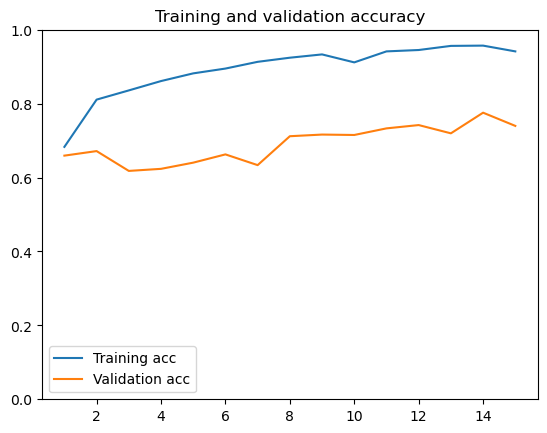

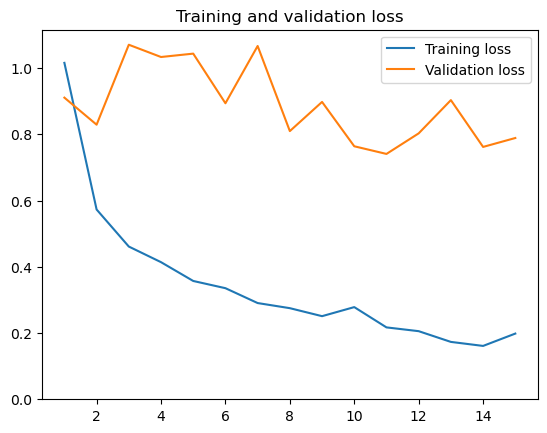

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylim(0, 1)
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylim(0)
plt.legend()

plt.show()

In [13]:
path_valid = "data/validation"
valid_suite = load_raw_suite(path_valid)

X_valid, y_valid = lstm.load_data(valid_suite, window_size=window)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], features)

y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)

y_valid = np.array(y_valid.idxmax(axis=1))

# print(y_pred)
# print(y_valid)

accuracy = np.mean(y_pred == y_valid)
print("Validation: Accuracy: %.2f%%" % (accuracy * 100.0))

path_valid = "data/test"
valid_suite = load_raw_suite(path_valid)

X_valid, y_valid = lstm.load_data(valid_suite, window_size=window)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], features)

y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)

y_valid = np.array(y_valid.idxmax(axis=1))

# print(y_pred)
# print(y_valid)

accuracy = np.mean(y_pred == y_valid)
print("Test: Accuracy: %.2f%%" % (accuracy * 100.0))

Loading data...
Done

2/2 [==============================] - 0s 12ms/step
Validation: Accuracy: 70.45%
Loading data...
Done

27/27 [==============================] - 0s 14ms/step
Test: Accuracy: 79.86%


In [14]:
# Results for 10 runs, 15 epochs, 32 batch size, 32 hidden units, 128 window size

v =  [52.27, 38,64, 43.18, 72.73, 61.36, 52.27, 68.18, 59.09, 61.36, 77.27]
t = [79.62, 74.61, 79.26, 73.90, 79.74, 74.02, 70.68, 73.90, 75.33, 74.73]

print(f"Valid mean: {np.mean(v)}, std: {np.std(v)}, min: {np.min(v)}, max: {np.max(v)}")
print(f"Test mean: {np.mean(t)}, std: {np.std(t)}, min: {np.min(t)}, max: {np.max(t)}")

Valid mean: 59.06454545454546, std: 11.379957951381305, min: 38.0, max: 77.27
Test mean: 75.57900000000001, std: 2.8457668562269807, min: 70.68, max: 79.74
